In [2]:
%pylab inline
import numpy as np
from numpy import *
import scipy.ndimage
import scipy
import h5py
import glob
import matplotlib.pyplot as pyplot
from matplotlib.pyplot import *

import matplotlib.pylab as pylab
import sklearn.feature_extraction
from IPython import display
pylab.rcParams['figure.figsize'] = (15.0, 20.0)

Populating the interactive namespace from numpy and matplotlib


In [3]:
all_x = {}
stain_categories = {'aztec': [], 
                    'coffee': [], 
                    'crumpled': [],
                    'folded': [], 
                    'sans': [], 
                    'sans-italics': [],
                    'serif': [],
                    'serif-italics': [],
                    'mono': [],
                    'mono-italics': []
                   }
for img in glob.glob('train/*.png'):
    imnum = int(''.join([c for c in img if c.isdigit()]))
    all_x[imnum] =  pyplot.imread(img)

for category in stain_categories.keys():
    for img in glob.glob('train-categorized/%s/*.png' % category):
        imnum = int(''.join([c for c in img if c.isdigit()]))
        stain_categories[category].append(imnum)

In [4]:
def fetch_images(requirements=None):
    if requirements is None:
        requirements = stain_categories.keys()
    
    sets = []
    
    for requirement in requirements:
        sets.append(set(stain_categories[requirement]))
    imgs = sets[0]
    for s in sets[1:]:
        imgs = imgs.intersection(s)
    images = {}
    for k in imgs:
        images[k] = all_x[k]
    return images

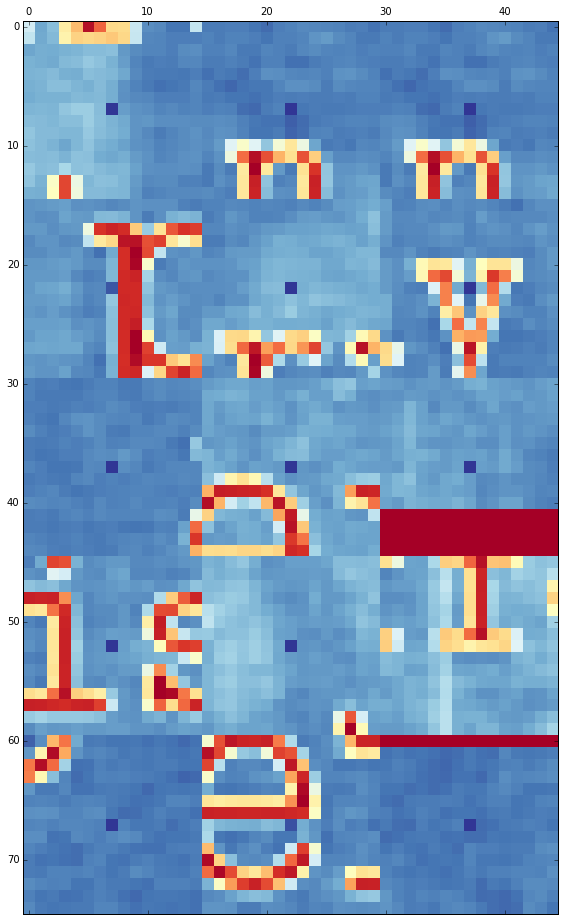

In [46]:
patch_size = 15
patch_center = patch_size / 2
max_patches = 100
n_images = 20


def enlargen_image(image):
    enlargened_size = (image.shape[0] + patch_center*2, image.shape[1] + patch_center*2)
    enlargened_image = np.zeros(enlargened_size, dtype=np.float32)
    enlargened_image[patch_center:-patch_center, patch_center:-patch_center] = image
    return enlargened_image

def batch(requirements):
    images = np.random.choice(fetch_images(requirements).keys(), n_images)

    X_patches = np.zeros((0, patch_size, patch_size))
    y_patches = np.zeros((0, patch_size, patch_size))

    for image in images:
        X_image = imread('train/%d.png' % image)
        y_image = imread('train_cleaned/%d.png' % image)

        enlargened_X = enlargen_image(X_image)
        features = [enlargened_X]
        enlargened_y = enlargen_image(y_image)

        def patchify(img):
            return sklearn.feature_extraction.image.extract_patches_2d(
                img, 
                (patch_size, patch_size), 
                max_patches=max_patches,
                random_state=rand_seed)
        rand_seed = np.random.randint(0, 1000000)

        X_ps = [patchify(feature) for feature in features]
        X_concatpatches = np.concatenate(X_ps, axis=1)

        X_patches = np.concatenate([X_patches, X_concatpatches])
        y_p = sklearn.feature_extraction.image.extract_patches_2d(
            enlargened_y,
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=rand_seed)
        y_patches = np.concatenate([y_patches, y_p])

    y_cls = y_patches[:, patch_center, patch_center]
    X_patches = X_patches[:, newaxis, :, :]

    return X_patches, y_cls

def view_batch():
    xs, ys = batch(['aztec', 'mono'])
    choices = np.random.choice(xs.shape[0], 3)
    ximgs = xs[choices, 0]
    ximgs[:, patch_size/2, patch_size/2] = ys.flatten()[choices]
    return np.concatenate(ximgs, axis=1)
#xs, ys = train_batch()
matshow(np.concatenate([view_batch() for _ in range(5)]), cmap='RdYlBu')

In [24]:
def patchify(img):
    return sklearn.feature_extraction.image.extract_patches_2d(img, (patch_size, patch_size))
    
def apply_model(image, exp):
    features = [image]
    patches = np.concatenate([patchify(f) for f in features], axis=1)
    patches = patches[:, newaxis, :, :]
    denoised_values = exp.predict({'input': patches})['output']
    #return denoised_values
    return clip(denoised_values, 0, 1)

def runtest(images):
    imchoice = np.random.choice(images)
    actual = imread('train/%d.png' % imchoice).astype(np.float32)
    cleaned = imread('train_cleaned/%d.png' % imchoice).astype(np.float32)

    image = enlargen_image(actual)
    denoised = apply_model(image, model)
    pred = denoised.reshape(actual.shape)

    diff = np.abs(cleaned - pred)*5
    err = sklearn.metrics.mean_squared_error(cleaned, pred)**0.5

    return np.clip(np.concatenate([
            np.concatenate([actual, pred], axis=1),
            np.concatenate([diff, cleaned], axis=1)
        ]), -1, 2), err

In [16]:
import keras.models
import keras.layers.core as kcore
import keras.layers.normalization as knorm

In [10]:
import theano.tensor as T
import theano
import sklearn.metrics

def truncating_func(output):
    #return output
    upper_trunc = T.switch(T.ge(output, 1), 1 + (output - 1) * 0.05, output)
    lower_trunc = T.switch(T.ge(0, upper_trunc), upper_trunc * 0.05, upper_trunc)
    return lower_trunc

def clipping_mse(y_true, y_pred):
    y_trunc = truncating_func(y_pred)
    diff = (y_true - y_trunc)**2
    return diff.mean()

y_true = T.as_tensor(np.random.normal(size=500))
y_pred = T.as_tensor(np.random.normal(size=500))
fn = theano.function([], clipping_mse(y_true, y_pred), allow_input_downcast=True)
fn(), sklearn.metrics.mean_squared_error(y_true.value, y_pred.value)

(array(1.2485927642072836), 1.9229597001630276)

In [62]:
full_image_size = patch_size*patch_size
expansion = 2
activation = 'sigmoid'

model = keras.models.Graph()
model.add_input('input', ndim=4)

model.add_node(kcore.Flatten(), name='flatin', input='input')

model.add_node(kcore.Dense(full_image_size, full_image_size*expansion, activation=activation),
               name='dense1', 
               input='flatin')

model.add_node(kcore.Dropout(0.5), name='drop1', input='dense1')
model.add_node(knorm.BatchNormalization((full_image_size*expansion, )), 
               input='dense1', 
               name='norm1')

model.add_node(kcore.Dense(full_image_size*expansion, full_image_size*expansion, activation=activation), 
               name='dense2', input='norm1')
model.add_node(kcore.Dropout(0.5), name='drop2', input='dense2')
model.add_node(knorm.BatchNormalization((full_image_size*expansion, )), 
               input='dense2', 
               name='norm2')

#model.add_node(kconv.Convolution2D(16, 1, 5, 5, activation='relu'), name='conv1', input='input')
#model.add_node(kcore.Flatten(), name='convflatten', input='conv1')

model.add_node(kcore.Dense(full_image_size*expansion, full_image_size*expansion, activation=activation), 
               name='dense3', input='norm2')
model.add_node(kcore.Dropout(0.5), name='drop3', input='dense3')
model.add_node(knorm.BatchNormalization((full_image_size*expansion, )), 
               input='dense3',
               name='norm3')

model.add_node(kcore.Dense(full_image_size*expansion, full_image_size*expansion, activation=activation), 
               name='dense4', 
               input='norm3')

model.add_node(kcore.Dense(full_image_size*expansion, 1, activation='linear'), 
               name='outmerge', input='dense4')
model.add_output('output', input='outmerge')

model.compile('rmsprop', {'output': clipping_mse})

xs, ys = batch(['crumpled', 'serif-italics'])
model.predict({'input': xs[:100]})['output'].flatten()
errs = []
n_epoch = 0

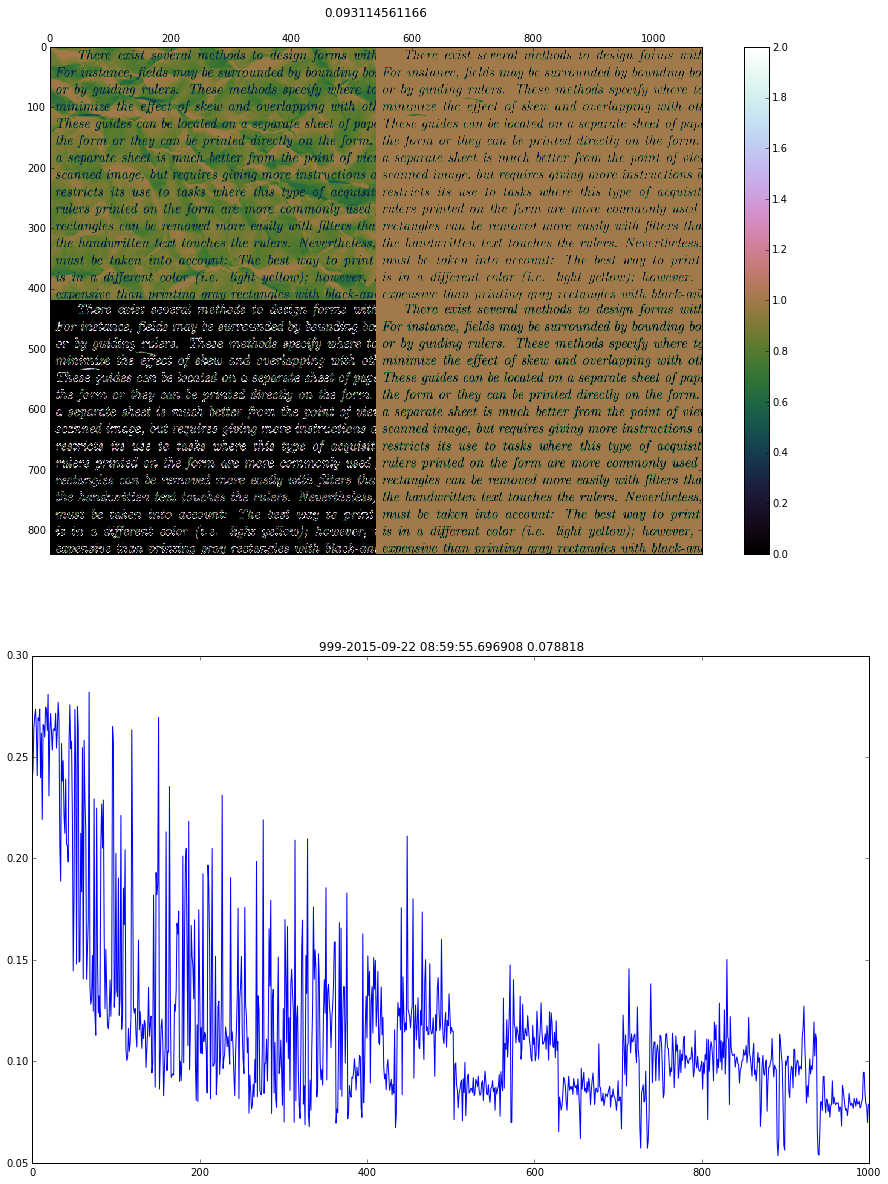

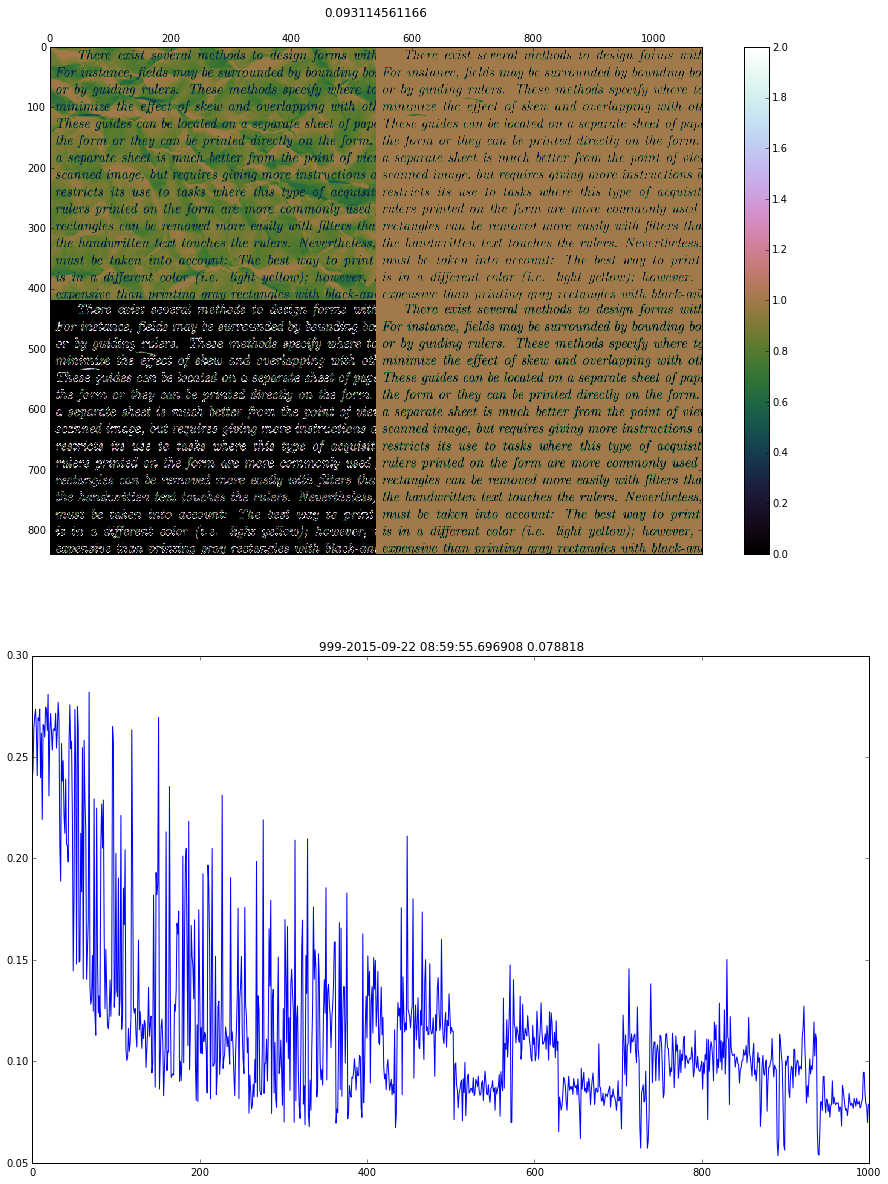

In [63]:
while n_epoch < 1000: 
    xs, ys = batch(['crumpled', 'serif-italics'])
    
    for _ in range(10):
        err = model.train_on_batch({'input': xs, 'output': ys[:, newaxis]})
    errs.append(err**0.5)
    if n_epoch % 10 == 0:
        immat, img_err = runtest(fetch_images(['crumpled', 'serif-italics']).keys())
    
    pyplot.clf()
    fig = pyplot.figure(1)
    ax1 = pyplot.subplot(211)
    
    im = ax1.matshow(immat, cmap='cubehelix')
    plt.colorbar(im)
    ax2 = pyplot.subplot(212)
    
    ax2.plot(errs)
    #ax2.set_ylim(0, 0.12)
    
    ax1.set_title(img_err)
    ax2.set_title("%d-%s %04f" % (n_epoch, datetime.datetime.now(), err ** 0.5))
    display.clear_output(wait=True)
    display.display(pyplot.gcf())
    n_epoch += 1